<a href="https://colab.research.google.com/github/hyunjae97/2023S-Ajou-ML/blob/main/COD_N_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. import library

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. load data

In [ ]:
#!unzip -qq "/content/drive/Shareddrives/COD-N_suhyeon/medicine_all.zip"

In [ ]:
# 데이터 경로 설정
data_dir = '/content/drive/Shareddrives/기계학습/Unzip_TS/medicine_all'
num_classes = len(os.listdir(data_dir))

In [ ]:
# 약 이름 딕셔너리 초기화
drug_names = {}

# 데이터 폴더 순회
for idx, label_name in enumerate(os.listdir(data_dir)):
    # 약 이름 딕셔너리에 약 이름과 인덱스 매핑
    drug_names[idx] = label_name

# 클래스 수 계산
num_classes = len(drug_names)

# 결과 출력
print('약 이름 딕셔너리:', drug_names)
print('클래스 수:', num_classes)

약 이름 딕셔너리: {0: '노바코트정', 1: '레보테놀정 12.5mg', 2: '로사르젠정', 3: '로자살탄플러스정(비매품)', 4: '록프로정', 5: '브롱코박솜캡슐 20mg (소아용)', 6: '코자릴정', 7: '크라비트정 500mg', 8: '트레노캡슐', 9: '프라카논정 75mg', 10: '베아투스정', 11: '베아로탄정50mg', 12: '리셀톤캡슐6.0mg', 13: '뉴에르도테캡슐', 14: '라노펜세미정', 15: '뮤코원캡슐(에르도스테인)', 16: '락토엔큐캡슐(바실루스리케니포르미스균)', 17: '크라틴정5mg', 18: '비오메틱스캡슐(바실루스리케니포르미스균)', 19: '에피나레정', 20: '도네셉트정 5mg', 21: '누제정', 22: '에비시펜정', 23: '옥시크로린정 150mg', 24: '위더렌정', 25: '에페신SR정', 26: '세토리드정', 27: '에스티렌정', 28: '스파렌정', 29: '코팔먼정', 30: '카디아핀정10mg', 31: '투헬스연질캡슐250mg', 32: '훼로모아캡슐155mg', 33: '토파메이트정25mg', 34: '실론정237.5mg', 35: '레파드린정', 36: '알로탈정125mg', 37: '태극암로디핀정', 38: '토프리드정', 39: '라보펜정', 40: '할ᄅ

In [ ]:
# 이미지와 레이블을 저장할 리스트 생성
images = []
labels = []

# 데이터 불러오기
for label_idx, label_name in enumerate(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label_name)
    for image_name in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_name)
        image = cv2.imread(image_path)
        image = cv2.resize(image, (64, 64))  # 이미지 크기 조정
        images.append(image)
        labels.append(label_idx)

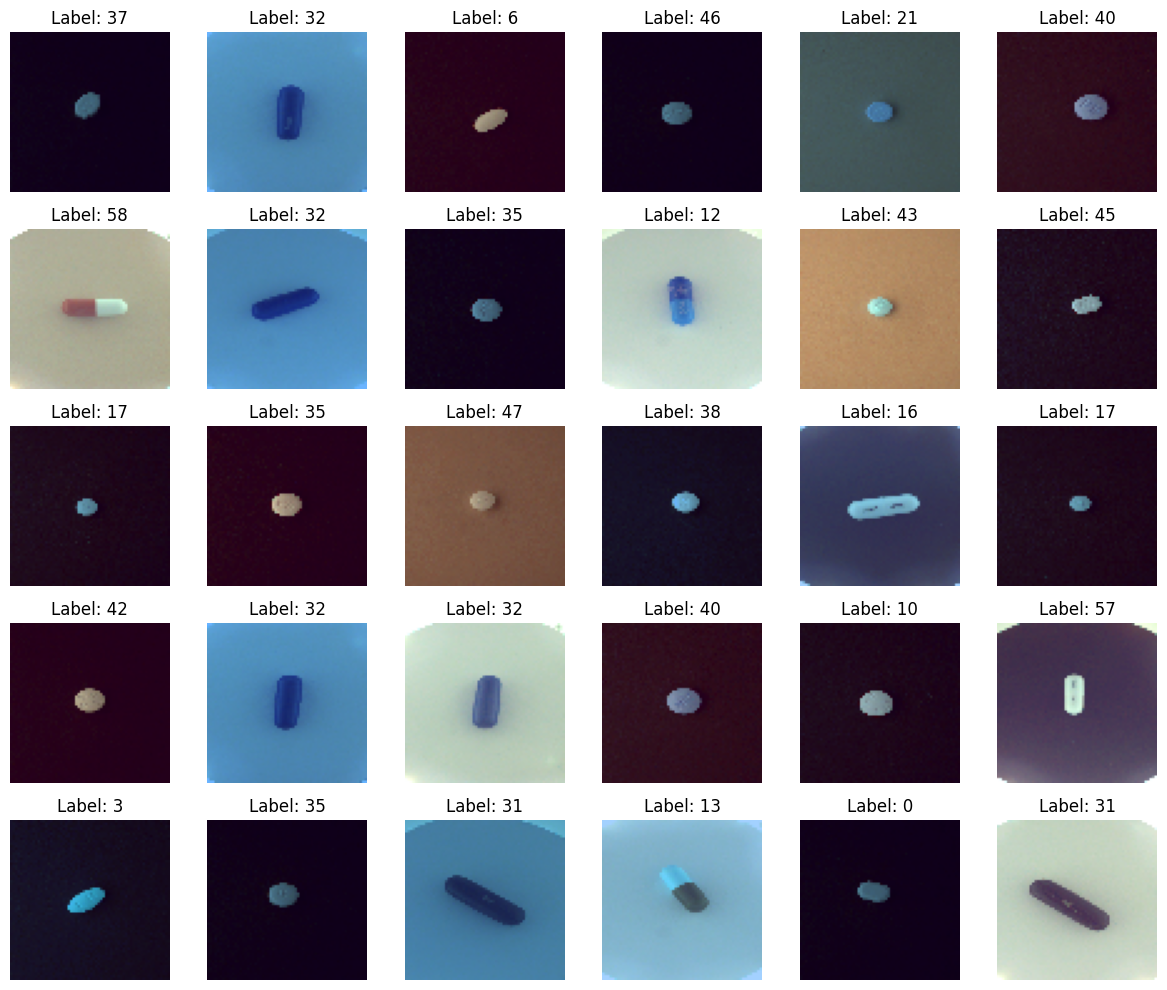

In [ ]:
# 데이터 이미지 확인
import matplotlib.pyplot as plt
import os
import cv2
import random

# 30개의 랜덤 이미지와 레이블 출력
num_images = 30  # 출력할 이미지의 개수
random_indices = random.sample(range(len(images)), num_images)

figure, axes = plt.subplots(nrows=5, ncols=6, figsize=(12, 10))

for i, idx in enumerate(random_indices):
    ax = axes[i // 6, i % 6]
    ax.imshow(images[idx])
    ax.axis('off')
    ax.set_title(f'Label: {labels[idx]}')
    
plt.tight_layout()
plt.show()

## 2.pre-processing

In [ ]:
# NumPy 배열로 변환
images = np.array(images)
labels = np.array(labels)

# 훈련 세트와 테스트 세트로 데이터 분할
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels)

# 데이터 전처리
train_images = train_images / 255.0
test_images = test_images / 255.0

## 3. modeling

In [ ]:
# 모델 생성
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
train_labels = np.eye(num_classes)[train_labels.squeeze()]
test_labels = np.eye(num_classes)[test_labels.squeeze()]

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(train_images, train_labels, epochs=20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

## 4. test

In [ ]:
# 테스트 데이터로 모델 평가
loss, accuracy = model.evaluate(test_images, test_labels)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

92/92 [==============================] - 7s 75ms/step - loss: 0.0395 - accuracy: 0.9833
Test loss: 0.03948339447379112
Test accuracy: 0.9833390116691589


KeyError: ignored

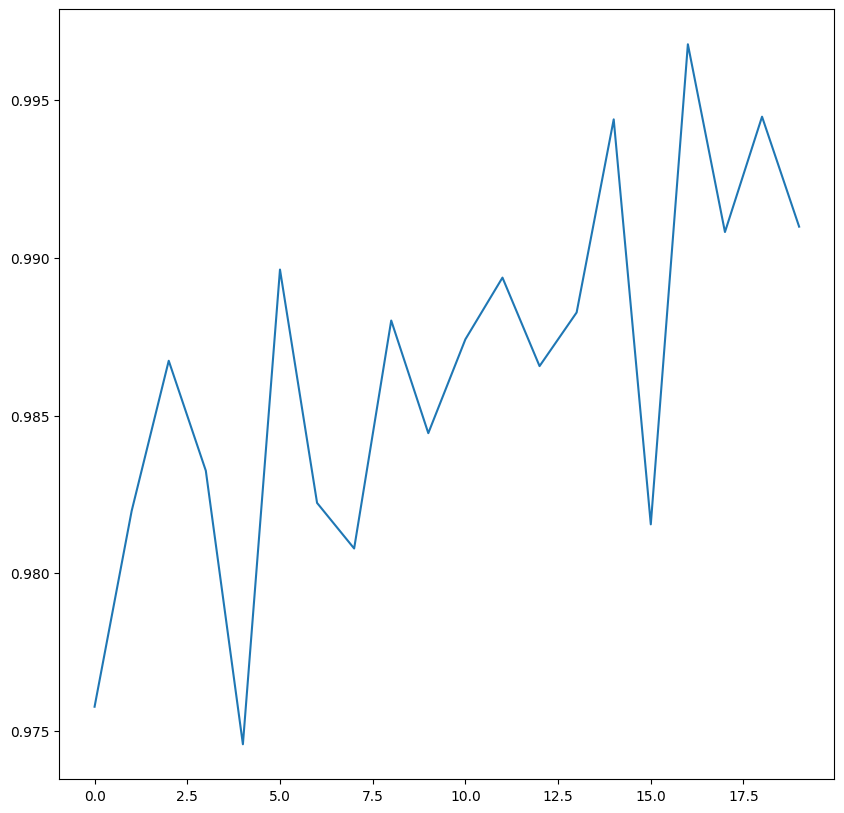

In [ ]:
# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Make predictions on the test set
y_pred = model.predict(test_images)

92/92 [==============================] - 8s 81ms/step


In [ ]:
# Convert one-hot encoded labels to integer labels
test_labels_int = np.argmax(test_labels, axis=1)

In [ ]:
# Compute ROC curve and ROC AUC score
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

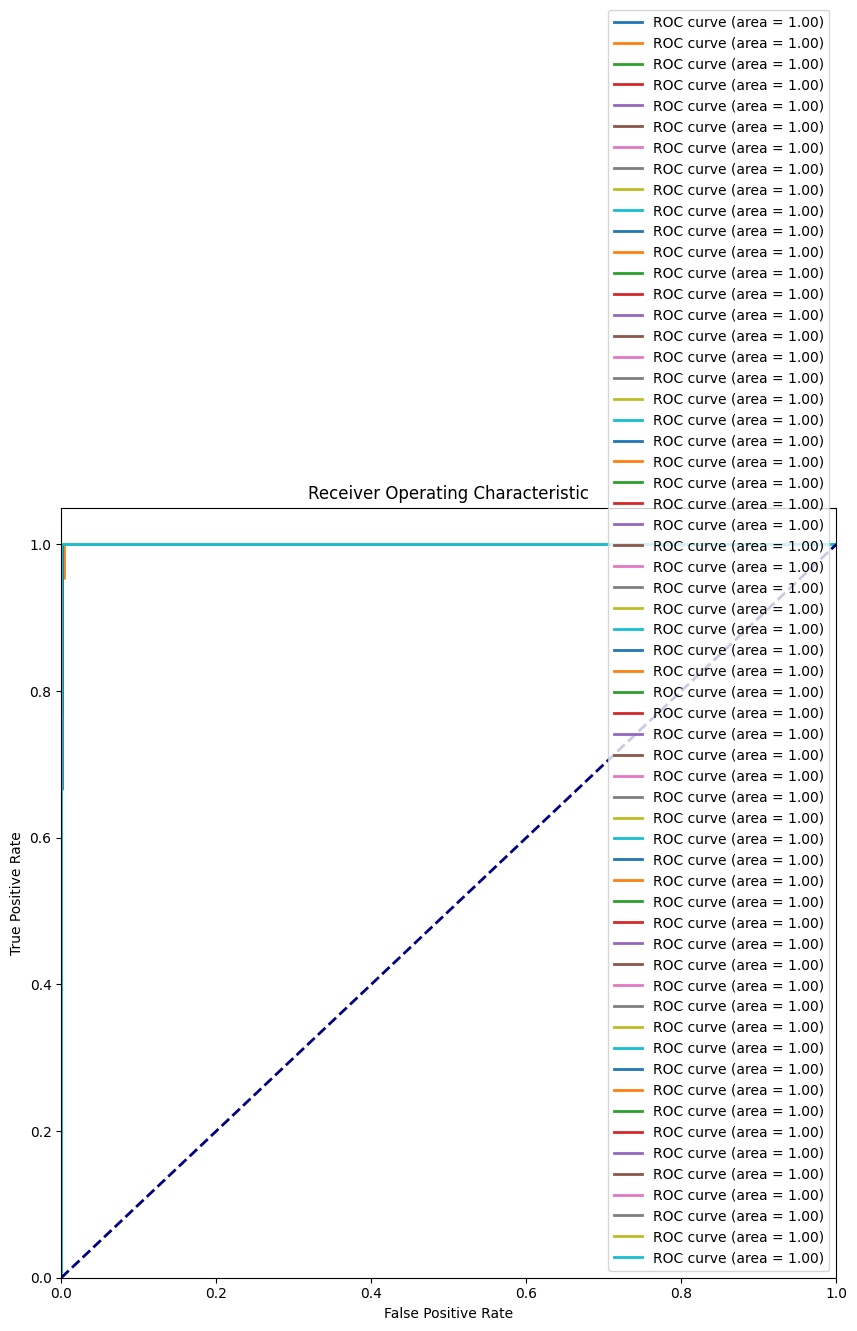

In [ ]:
# Plot ROC curve
plt.figure()
for i in range(num_classes):
  plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})') 
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute precision, recall, and thresholds for precision-recall curve
precision = dict()
recall = dict()
pr_auc = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(test_labels[:, i], y_pred[:, i])
    pr_auc[i] = auc(recall[i], precision[i])

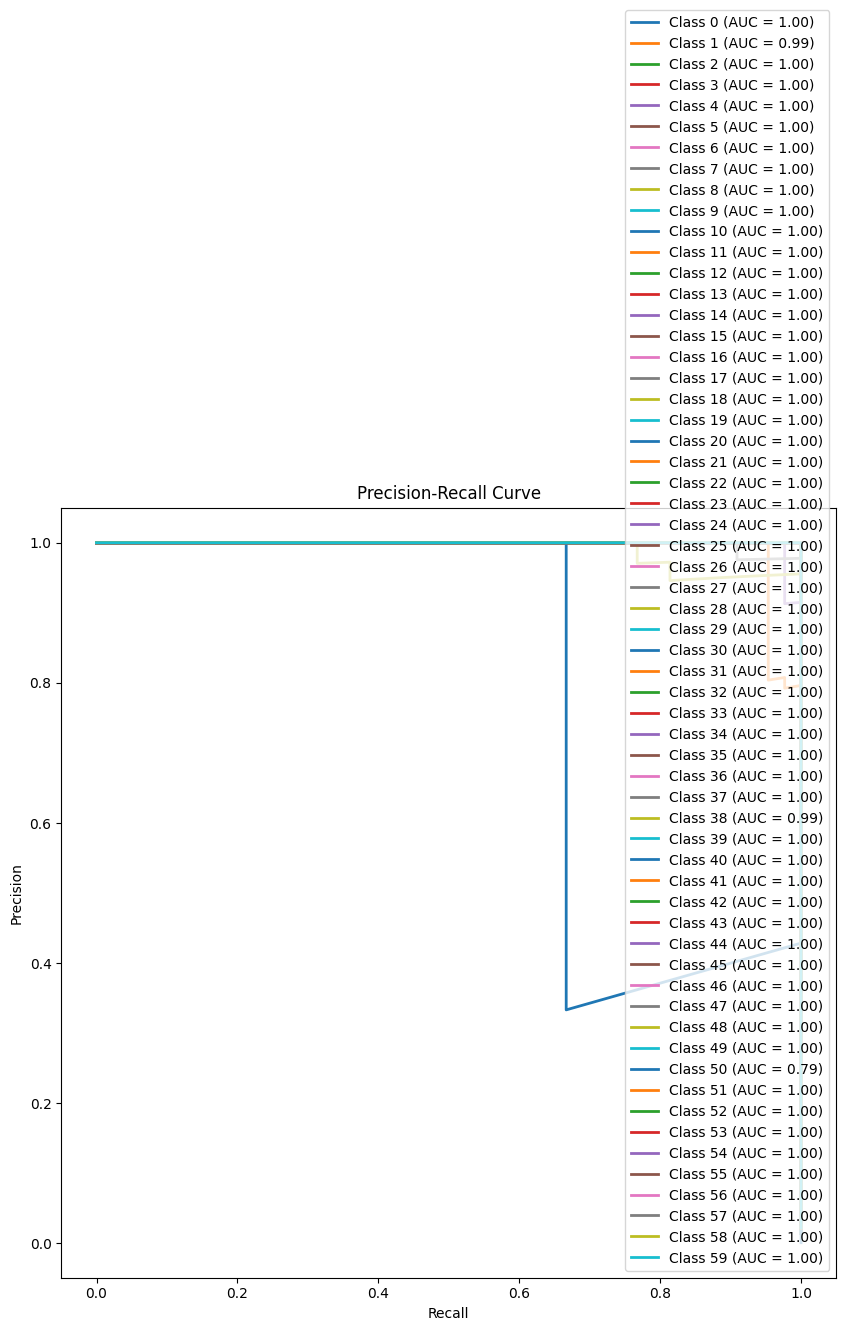

In [ ]:
# Plot precision-recall curve
plt.figure()
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {pr_auc[i]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Compute confusion matrix
y_pred_int = np.argmax(y_pred, axis=1)
cm = confusion_matrix(test_labels_int, y_pred_int)

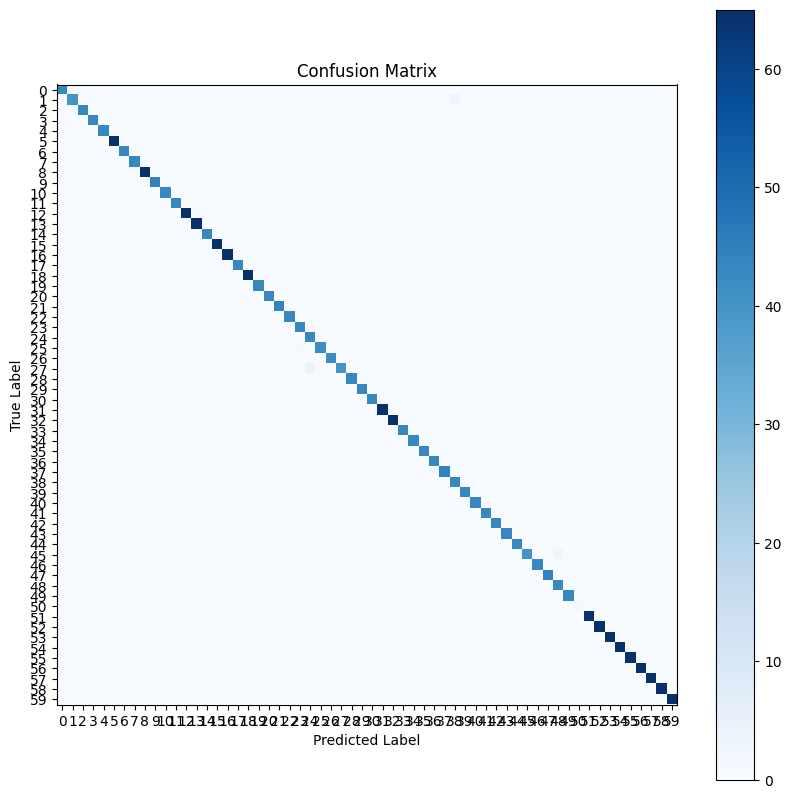

In [ ]:
# Plot confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import f1_score

# Compute F1 score for each class
f1_scores = []
for i in range(num_classes):
    f1 = f1_score(test_labels[:, i], np.round(y_pred[:, i]))
    f1_scores.append(f1)

# Print F1 score for each class
for i in range(num_classes):
    print(f"Class {i}: F1 score = {f1_scores[i]:.4f}")

# Compute average F1 score
average_f1 = np.mean(f1_scores)
print(f"---------------------------")
print(f"Average F1 score: {average_f1:.4f}")

Class 0: F1 score = 1.0000
Class 1: F1 score = 0.9639
Class 2: F1 score = 1.0000
Class 3: F1 score = 1.0000
Class 4: F1 score = 1.0000
Class 5: F1 score = 1.0000
Class 6: F1 score = 1.0000
Class 7: F1 score = 1.0000
Class 8: F1 score = 1.0000
Class 9: F1 score = 1.0000
Class 10: F1 score = 1.0000
Class 11: F1 score = 1.0000
Class 12: F1 score = 1.0000
Class 13: F1 score = 1.0000
Class 14: F1 score = 1.0000
Class 15: F1 score = 1.0000
Class 16: F1 score = 1.0000
Class 17: F1 score = 1.0000
Class 18: F1 score = 0.9924
Class 19: F1 score = 1.0000
Class 20: F1 score = 1.0000
Class 21: F1 score = 1.0000
Class 22: F1 score = 1.0000
Class 23: F1 score = 0.9885
Class 24: F1 score = 0.9556
Class 25: F1 score = 0.9882
Class 26: F1 score = 0.9882
Class 27: F1 score = 0.9524
Class 28: F1 score = 0.9885
Class 29: F1 score = 1.0000
Class 30: F1 score = 1.0000
Class 31: F1 score = 1.0000
Class 32: F1 score = 1.0000
Class 33: F1 score = 1.0000
Class 34: F1 score = 1.0000
Class 35: F1 score = 1.0000
Cl